# 🧠 RLHF Full Workflow (Unified Notebook)
This notebook trains PPO Expert, generates preference data using π₁ vs π₂, trains PPO-RLHF using RewardNet, and then trains a DPO policy — all within one integrated flow. Supports both discrete and continuous environments.

## 📦 Step 1: Setup and Imports

In [7]:
import os
import gymnasium as gym
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.policies import ActorCriticPolicy


## ⚙️ Step 2: Environment Setup

In [8]:
# ===== 🧩 参数设置：用于控制整个训练/偏好/可视化流程 =====

env_id = "CartPole-v1"     # 任务环境名称（可选：CartPole-v1, Pendulum-v1, Acrobot-v1, MountainCar-v0, MountainCarContinuous-v0）

seed = 42                  # 随机种子，保证实验可复现

total_timesteps = 30000   # Expert PPO 训练步数（CartPole 推荐 40k，Pendulum 推荐 150k，MountainCar 100k+）

num_prefs = 500         # 偏好样本数量（500 表示生成 250 对 expert vs pi2 的比较）

sample_length = 500        # 每条轨迹最大长度（CartPole 建议 200，Pendulum 建议 200，MountainCar 建议 300–1000）

# ===========================================================


set_random_seed(seed)

env = Monitor(gym.make(env_id))
is_discrete = hasattr(env.action_space, "n")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if is_discrete else env.action_space.shape[0]
print(f"✅ Environment: {env_id} | Action space: {'Discrete' if is_discrete else 'Continuous'}")


✅ Environment: CartPole-v1 | Action space: Discrete


## 🧠 Step 3: Train PPO Expert (π₁) and Save Checkpoints

In [9]:
checkpoint_dir = f"./checkpoints_{env_id.replace('-', '_')}"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = CheckpointCallback(
    save_freq=total_timesteps // 10,
    save_path=checkpoint_dir,
    name_prefix="ppo"
)

expert_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
expert_model.learn(total_timesteps=total_timesteps, callback=checkpoint_callback)
expert_model.save(f"{env_id}_expert_seed{seed}.zip")
env.close()


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.6     |
|    ep_rew_mean     | 23.6     |
| time/              |          |
|    fps             | 636      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.6        |
|    ep_rew_mean          | 27.6        |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008758044 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_vari

## 🧪 Step 4: Select π₂ (Half-Performance PPO Checkpoint)

In [10]:
def evaluate_policy(model, env, episodes=30):
    scores = []
    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        total = 0
        while not done:
            action, _ = model.predict(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        scores.append(total)
    return np.mean(scores)

env = gym.make(env_id)
checkpoints = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".zip")])
rewards = [(f, evaluate_policy(PPO.load(os.path.join(checkpoint_dir, f), env=env), env)) for f in checkpoints]
best_reward = max(rewards, key=lambda x: x[1])[1]
target = best_reward * 0.5
rewards.sort(key=lambda x: abs(x[1] - target))
pi2_model = PPO.load(os.path.join(checkpoint_dir, rewards[0][0]), env=env)
print(f"✅ Selected π₂: {rewards[0][0]} with ~{rewards[0][1]:.1f} reward")


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


d:\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(
d:\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\save_util.py:165: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API.

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

## ❤️ Step 5: Generate Preferences (π₁ vs π₂)

In [29]:
import numpy as np
import pickle
from tqdm import trange  # 🔥 进度条

def generate_trajectory(model, env, is_discrete, max_steps=200):
    obs_list, act_list, rewards = [], [], []
    obs, _ = env.reset()
    for _ in range(max_steps):
        action, _ = model.predict(obs)

        # ✅ 强制处理动作格式
        if is_discrete:
            action = int(action)  # e.g. 0, 1, 2...
        else:
            action = np.array(action, dtype=np.float32)  # 保证是 1D np.array
        
        obs_, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        obs_list.append(obs)
        act_list.append(action)
        rewards.append(reward)

        obs = obs_
        if done:
            break

    return {
        "obs": obs_list,      # list of obs, e.g. [np.array(obs_dim)]
        "acts": act_list,     # list of int or np.array
        "rews": rewards       # list of floats
    }


def compute_return(traj):
    return sum(traj["rews"])

def soft_preference_prob(R1, R2):
    max_r = max(R1, R2)
    return np.exp(R1 - max_r) / (np.exp(R1 - max_r) + np.exp(R2 - max_r))

# 采样偏好数据 + 进度条
prefs = []
for _ in trange(num_prefs, desc="🔄 Generating preference pairs"):
    traj1 = generate_trajectory(expert_model, env, is_discrete=is_discrete)
    traj2 = generate_trajectory(pi2_model, env, is_discrete=is_discrete)
    R1, R2 = compute_return(traj1), compute_return(traj2)
    p = soft_preference_prob(R1, R2)
    label = int(np.random.rand() < p)
    prefs.append((traj1, traj2, label))

# 保存为 .pkl
filename = f"prefs_{env_id}_seed{seed}.pkl"
with open(filename, "wb") as f:
    pickle.dump(prefs, f)

print(f"✅ Saved {len(prefs)} preference pairs to {filename}")




🔄 Generating preference pairs: 100%|██████████| 500/500 [01:53<00:00,  4.39it/s]


✅ Saved 500 preference pairs to prefs_CartPole-v1_seed42.pkl


## 🧱 Step 6: Define Shared Policy Network for DPO and PPO-RLHF

In [12]:
class SharedPolicyNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete, hidden_size=64):
        super().__init__()
        self.is_discrete = is_discrete
        if is_discrete:
            self.net = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
        else:
            self.mu = nn.Sequential(
                nn.Linear(obs_dim, hidden_size),
                nn.ReLU(),
                nn.Linear(hidden_size, act_dim)
            )
            self.log_std = nn.Parameter(torch.zeros(act_dim))

    def forward(self, obs):
        if self.is_discrete:
            return self.net(obs)
        else:
            mu = self.mu(obs)
            std = self.log_std.exp().expand_as(mu)
            return mu, std

    def select_action(self, obs):
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            logits = self.forward(obs)
            probs = torch.softmax(logits, dim=-1)
            return probs.multinomial(num_samples=1).item()
        else:
            mu, std = self.forward(obs)
            dist = torch.distributions.Normal(mu, std)
            return dist.sample().squeeze(0).detach().numpy()


## ⚙️ Step 7: Train DPO Policy

In [13]:
def train_dpo(prefs, obs_dim, act_dim, is_discrete, epochs=600, batch_size=16, device='cpu'):
    policy = SharedPolicyNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)
    for epoch in range(epochs):
        np.random.shuffle(prefs)
        total_loss = 0
        for i in range(0, len(prefs), batch_size):
            batch = prefs[i:i + batch_size]
            losses = []
            for traj1, traj2, label in batch:
                s1 = torch.tensor(np.stack(traj1['obs']), dtype=torch.float32, device=device)
                s2 = torch.tensor(np.stack(traj2['obs']), dtype=torch.float32, device=device)
                # For discrete action space: convert each action to int
                if is_discrete:
                    a1 = torch.tensor([int(a) for a in traj1['acts']], dtype=torch.long, device=device)
                    a2 = torch.tensor([int(a) for a in traj2['acts']], dtype=torch.long, device=device)
                else:
                    a1 = torch.tensor(np.array(traj1['acts']), dtype=torch.float32, device=device)
                    a2 = torch.tensor(np.array(traj2['acts']), dtype=torch.float32, device=device)

                if is_discrete:
                    logp1 = torch.log_softmax(policy(s1), dim=-1)
                    logp2 = torch.log_softmax(policy(s2), dim=-1)
                    lp1 = logp1[torch.arange(len(a1)), a1].sum()
                    lp2 = logp2[torch.arange(len(a2)), a2].sum()
                else:
                    mu1, std1 = policy(s1)
                    mu2, std2 = policy(s2)
                    dist1 = torch.distributions.Normal(mu1, std1)
                    dist2 = torch.distributions.Normal(mu2, std2)
                    lp1 = dist1.log_prob(a1).sum()
                    lp2 = dist2.log_prob(a2).sum()

                label_tensor = torch.tensor(label, dtype=torch.float32, device=device)
                loss = F.binary_cross_entropy_with_logits((lp1 - lp2).view(1), label_tensor.view(1))
                losses.append(loss)

            batch_loss = torch.stack(losses).mean()
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(prefs):.4f}")
    return policy

with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:100]

dpo_model = train_dpo(prefs, obs_dim, act_dim, is_discrete)
torch.save(dpo_model.state_dict(), f"{env_id}_dpo_seed{seed}.pth")


Epoch 1/600, Loss: 12.5372
Epoch 2/600, Loss: 12.0952
Epoch 3/600, Loss: 10.9881
Epoch 4/600, Loss: 10.4675
Epoch 5/600, Loss: 9.3766
Epoch 6/600, Loss: 7.3173
Epoch 7/600, Loss: 4.9480
Epoch 8/600, Loss: 2.9328
Epoch 9/600, Loss: 2.0578
Epoch 10/600, Loss: 1.8307
Epoch 11/600, Loss: 1.8007
Epoch 12/600, Loss: 1.3666
Epoch 13/600, Loss: 1.3855
Epoch 14/600, Loss: 1.9484
Epoch 15/600, Loss: 1.7797
Epoch 16/600, Loss: 1.7610
Epoch 17/600, Loss: 1.2574
Epoch 18/600, Loss: 1.2344
Epoch 19/600, Loss: 1.2309
Epoch 20/600, Loss: 1.2109
Epoch 21/600, Loss: 1.3107
Epoch 22/600, Loss: 1.1939
Epoch 23/600, Loss: 1.5610
Epoch 24/600, Loss: 1.1855
Epoch 25/600, Loss: 1.5201
Epoch 26/600, Loss: 1.1699
Epoch 27/600, Loss: 1.1663
Epoch 28/600, Loss: 1.1542
Epoch 29/600, Loss: 1.5560
Epoch 30/600, Loss: 1.1390
Epoch 31/600, Loss: 1.1316
Epoch 32/600, Loss: 1.4768
Epoch 33/600, Loss: 1.1304
Epoch 34/600, Loss: 1.1077
Epoch 35/600, Loss: 1.0894
Epoch 36/600, Loss: 1.0853
Epoch 37/600, Loss: 1.5178
Epoch 

In [30]:
import torch
import torch.nn.functional as F
import copy
from stable_baselines3 import PPO

def train_dpo_from_ref(
    prefs, ref_policy_sb3, obs_dim, act_dim, is_discrete,
    beta=0.05, seed=0, epochs=20, batch_size=16, device='cpu'
):
    torch.manual_seed(seed)

    # 准备 policy：复制自参考策略 π_ref
    ref_policy = ref_policy_sb3.policy
    ref_policy.eval().to(device)

    policy = copy.deepcopy(ref_policy)
    policy.train().to(device)

    optimizer = torch.optim.Adam(policy.parameters(), lr=1e-3)

    for epoch in range(epochs):
        torch.random.manual_seed(epoch + seed)
        np.random.shuffle(prefs)
        total_loss = 0

        for i in range(0, len(prefs), batch_size):
            batch = prefs[i:i + batch_size]
            losses = []

            for traj1, traj2, label in batch:
                s1 = torch.tensor(np.stack(traj1["obs"]), dtype=torch.float32, device=device)
                s2 = torch.tensor(np.stack(traj2["obs"]), dtype=torch.float32, device=device)

                if is_discrete:
                    a1 = torch.tensor(traj1["acts"], dtype=torch.long, device=device)
                    a2 = torch.tensor(traj2["acts"], dtype=torch.long, device=device)
                else:
                    a1 = torch.tensor(np.array(traj1["acts"]), dtype=torch.float32, device=device)
                    a2 = torch.tensor(np.array(traj2["acts"]), dtype=torch.float32, device=device)

                # --- 当前 policy ---
                dist1 = policy.get_distribution(s1)
                dist2 = policy.get_distribution(s2)
                logp1 = dist1.log_prob(a1).sum()
                logp2 = dist2.log_prob(a2).sum()

                # --- 参考 policy ---
                with torch.no_grad():
                    ref_dist1 = ref_policy.get_distribution(s1)
                    ref_dist2 = ref_policy.get_distribution(s2)
                    ref_logp1 = ref_dist1.log_prob(a1).sum()
                    ref_logp2 = ref_dist2.log_prob(a2).sum()

                # --- DPO Loss ---
                adv1 = logp1 - ref_logp1
                adv2 = logp2 - ref_logp2
                logits = beta * (adv1 - adv2)

                label_tensor = torch.tensor(label, dtype=torch.float32, device=device)
                loss = F.binary_cross_entropy_with_logits(logits.view(1), label_tensor.view(1))
                losses.append(loss)

            # 批次梯度下降
            batch_loss = torch.stack(losses).mean()
            optimizer.zero_grad()
            batch_loss.backward()
            torch.nn.utils.clip_grad_norm_(policy.parameters(), 1.0)
            optimizer.step()
            total_loss += batch_loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {total_loss / (len(prefs) // batch_size):.4f}")

    return policy


with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:100]

dpo_model = train_dpo_from_ref(
    prefs,
    ref_policy_sb3=pi2_model,
    obs_dim=obs_dim,
    act_dim=act_dim,
    is_discrete=is_discrete,
    beta=10,
    seed=seed,
    device = 'cpu'
)

torch.save(dpo_model.state_dict(), f"{env_id}_dpo_pi2_seed{seed}.pth")



ValueError: Value is not broadcastable with batch_shape+event_shape: torch.Size([200]) vs torch.Size([96]).

## 🧠 Step 8: Train RewardNet from Preferences (for PPO-RLHF)

In [14]:
class RewardNet(nn.Module):
    def __init__(self, obs_dim, act_dim, is_discrete=True, hidden_size=64):
        super().__init__()
        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.is_discrete = is_discrete
        self.net = nn.Sequential(
            nn.Linear(obs_dim + (act_dim if is_discrete else act_dim), hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, states, actions):
        if self.is_discrete:
            one_hot = F.one_hot(actions.view(-1), num_classes=self.act_dim).float()
            x = torch.cat([states, one_hot], dim=-1)
        else:
            x = torch.cat([states, actions], dim=-1)
        return self.net(x).squeeze(-1)

def train_reward_model(prefs, obs_dim, act_dim, is_discrete, epochs=600, batch_size=16, lr=1e-3, device='cpu'):
    model = RewardNet(obs_dim, act_dim, is_discrete).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(epochs):
        np.random.shuffle(prefs)
        total_loss = 0.0
        for i in range(0, len(prefs), batch_size):
            batch = prefs[i:i + batch_size]
            losses = []
            for traj1, traj2, label in batch:
                s1 = torch.tensor(np.stack(traj1['obs']), dtype=torch.float32, device=device)
                s2 = torch.tensor(np.stack(traj2['obs']), dtype=torch.float32, device=device)
                if is_discrete:
                    a1 = torch.tensor([int(a) for a in traj1['acts']], dtype=torch.long, device=device)
                    a2 = torch.tensor([int(a) for a in traj2['acts']], dtype=torch.long, device=device)
                else:
                    a1 = torch.tensor(np.stack(traj1['acts']), dtype=torch.float32, device=device)
                    a2 = torch.tensor(np.stack(traj2['acts']), dtype=torch.float32, device=device)
                r1 = model(s1, a1).sum()
                r2 = model(s2, a2).sum()
                y = torch.tensor(label, dtype=torch.float32, device=device)
                loss = criterion((r1 - r2).view(1), y.view(1))
                losses.append(loss)
            batch_loss = torch.stack(losses).mean()
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(prefs):.4f}")
    return model

with open(f"prefs_{env_id}_seed{seed}.pkl", "rb") as f:
    prefs = pickle.load(f)
prefs = prefs[:20]

reward_model = train_reward_model(prefs, obs_dim, act_dim, is_discrete)
torch.save(reward_model.state_dict(), f"reward_model_{env_id}_seed{seed}.pth")


Epoch 1/600, Loss: 0.4250
Epoch 2/600, Loss: 0.0022
Epoch 3/600, Loss: 0.0000
Epoch 4/600, Loss: 0.0000
Epoch 5/600, Loss: 0.0000
Epoch 6/600, Loss: 0.0000
Epoch 7/600, Loss: 0.0000
Epoch 8/600, Loss: 0.0000
Epoch 9/600, Loss: 0.0000
Epoch 10/600, Loss: 0.0000
Epoch 11/600, Loss: 0.0000
Epoch 12/600, Loss: 0.0000
Epoch 13/600, Loss: 0.0000
Epoch 14/600, Loss: 0.0000
Epoch 15/600, Loss: 0.0000
Epoch 16/600, Loss: 0.0000
Epoch 17/600, Loss: 0.0000
Epoch 18/600, Loss: 0.0000
Epoch 19/600, Loss: 0.0000
Epoch 20/600, Loss: 0.0000
Epoch 21/600, Loss: 0.0000
Epoch 22/600, Loss: 0.0000
Epoch 23/600, Loss: 0.0000
Epoch 24/600, Loss: 0.0000
Epoch 25/600, Loss: 0.0000
Epoch 26/600, Loss: 0.0000
Epoch 27/600, Loss: 0.0000
Epoch 28/600, Loss: 0.0000
Epoch 29/600, Loss: 0.0000
Epoch 30/600, Loss: 0.0000
Epoch 31/600, Loss: 0.0000
Epoch 32/600, Loss: 0.0000
Epoch 33/600, Loss: 0.0000
Epoch 34/600, Loss: 0.0000
Epoch 35/600, Loss: 0.0000
Epoch 36/600, Loss: 0.0000
Epoch 37/600, Loss: 0.0000
Epoch 38/6

## 🔁 Step 9: Train PPO-RLHF (Reward Finetuned from Expert π₁)

In [15]:
import gymnasium as gym
from gymnasium import Wrapper

class RewardNetWrapper(Wrapper):
    def __init__(self, env, reward_net, is_discrete):
        super().__init__(env)
        self.reward_net = reward_net
        self.is_discrete = is_discrete

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        # Convert to tensor
        obs_tensor = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        if self.is_discrete:
            act_tensor = torch.tensor([action], dtype=torch.long)
        else:
            act_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        # Predict learned reward
        with torch.no_grad():
            reward = self.reward_net(obs_tensor, act_tensor).item()

        return obs, reward, terminated, truncated, info

# 用训练好的 reward_net 包装环境
reward_model.eval()  # 保证模型处于推理模式
env = RewardNetWrapper(gym.make(env_id), reward_model,is_discrete)
env = Monitor(env)

# 重新训练策略，用的是新的 reward
rlhf_model = PPO("MlpPolicy", env, verbose=1, seed=seed)
rlhf_model.learn(total_timesteps=total_timesteps)
rlhf_model.save(f"{env_id}_rlhf_seed{seed}.zip")


Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.6     |
|    ep_rew_mean     | 5.38     |
| time/              |          |
|    fps             | 638      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30.9        |
|    ep_rew_mean          | 6.92        |
| time/                   |             |
|    fps                  | 533         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011724759 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.685      |
|    explained_vari

## 📊 Step 10: Compare PPO Expert vs PPO-RLHF vs DPO

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


C:\Users\zzy666\AppData\Local\Temp\ipykernel_3496\654682137.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dpo_model.load_state_dict(torch.load(f"{env_id}_dpo_seed{see

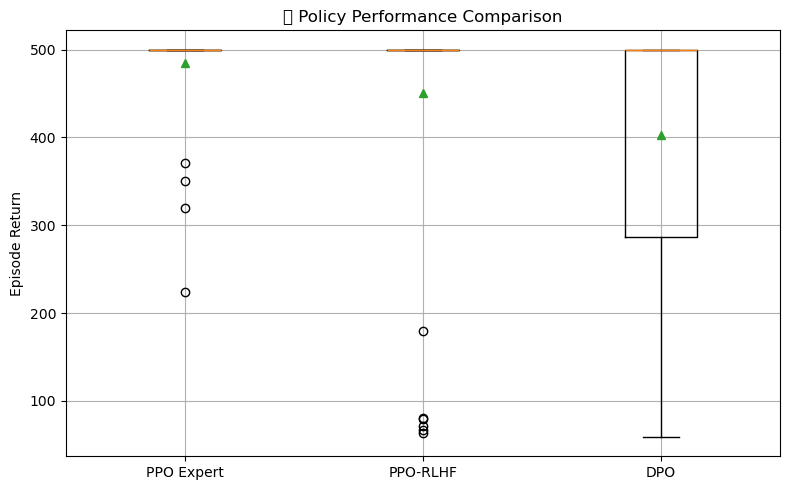

In [16]:
def eval_policy(model, env, is_sb3=True, episodes=50):
    returns = []
    for _ in range(episodes):
        obs, _ = env.reset()
        total = 0.0
        done = False
        while not done:
            action = model.predict(obs, deterministic=False)[0] if is_sb3 else model.select_action(obs)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total += reward
        returns.append(total)
    return returns


env = gym.make(env_id)
returns_expert = eval_policy(PPO.load(f"{env_id}_expert_seed{seed}.zip", env=env), env)
returns_rlhf   = eval_policy(PPO.load(f"{env_id}_rlhf_seed{seed}.zip", env=env), env)
dpo_model = SharedPolicyNet(obs_dim, act_dim, is_discrete)
dpo_model.load_state_dict(torch.load(f"{env_id}_dpo_seed{seed}.pth"))
returns_dpo    = eval_policy(dpo_model, env, is_sb3=False)

plt.figure(figsize=(8, 5))
plt.boxplot([returns_expert, returns_rlhf, returns_dpo],
            labels=["PPO Expert", "PPO-RLHF", "DPO"],
            showmeans=True)
plt.title("🎯 Policy Performance Comparison")
plt.ylabel("Episode Return")
plt.grid(True)
plt.tight_layout()
plt.show()



d:\anaconda3\envs\rl\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


d:\anaconda3\envs\rl\Lib\site-packages\pygame\pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists


✅ GIF saved to: d:\Users\zzy666\Desktop\ppodpo\CartPole-v1_comparison_seed42.gif


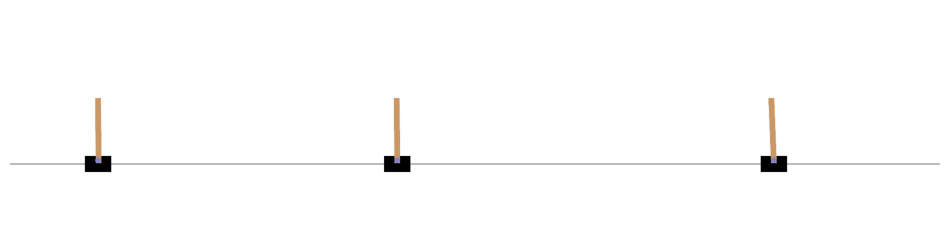

In [17]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
from stable_baselines3 import PPO
import os

# Step 1: 单次策略运行，记录图像帧
def record_episode(model, env, is_sb3=True, max_steps=1000):
    frames = []
    obs, _ = env.reset()
    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)
        action = model.predict(obs, deterministic=True)[0] if is_sb3 else model.select_action(obs)
        obs, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            break
    env.close()
    return frames

# Step 2: 拼接多组帧并显示为合成动画，同时保存为 GIF（可选）
def show_combined_animation(frames_list, fps=30, gif_path=None):
    min_len = min(len(f) for f in frames_list)
    fig = plt.figure(figsize=(12, 4))
    plt.axis('off')
    init_frame = np.hstack([f[0] for f in frames_list])
    im = plt.imshow(init_frame)

    def update(i):
        combined = np.hstack([f[i] for f in frames_list])
        im.set_array(combined)
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=min_len, interval=1000/fps)

    if gif_path:
        ani.save(gif_path, writer='pillow', fps=fps)
        print(f"✅ GIF saved to: {os.path.abspath(gif_path)}")

    return HTML(ani.to_jshtml())

# Step 3: 加载模型与环境
env_expert = gym.make(env_id, render_mode="rgb_array")
env_rlhf   = gym.make(env_id, render_mode="rgb_array")
env_dpo    = gym.make(env_id, render_mode="rgb_array")

expert_model = PPO.load(f"{env_id}_expert_seed{seed}.zip", env=env_expert)
rlhf_model   = PPO.load(f"{env_id}_rlhf_seed{seed}.zip", env=env_rlhf)

# Step 4: 收集三种策略的动画帧
frames_expert = record_episode(expert_model, env_expert)
frames_rlhf   = record_episode(rlhf_model, env_rlhf)
frames_dpo    = record_episode(dpo_model, env_dpo, is_sb3=False)

# Step 5: 显示合成动画，并保存为 GIF 文件
display(HTML("<h3>🎯 Strategy Animation Comparison: PPO Expert vs RLHF vs DPO</h3>"))
display(show_combined_animation(
    [frames_expert, frames_rlhf, frames_dpo],
    gif_path=f"{env_id}_comparison_seed{seed}.gif"
))




